In [1]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
import pandas as pd
import os
from scipy.stats import norm
import math
import operator

In [2]:
#Importación de datos

ruta_entrada= os.path.join( '.','data')
ruta_salida = os.path.join( '.','output')
datos_valledupar = 'Valledupar'
datos_ideam_valledupar = 'IDEAM'
ruta_serie_valledupar_ideam= os.path.join(ruta_entrada,datos_valledupar,datos_ideam_valledupar+'.csv')
ideam_valledupar= pd.read_csv(ruta_serie_valledupar_ideam, sep = ';',
                encoding='latin-1')
datos_nrel_valledupar = 'NREL'
ruta_serie_valledupar_nrel= os.path.join(ruta_entrada,datos_valledupar,datos_nrel_valledupar+'.csv')
nrel_valledupar= pd.read_csv(ruta_serie_valledupar_nrel, sep = ';',
                encoding='latin-1')

datos_uribia = 'Uribia'
datos_ideam_uribia = 'IDEAM'
ruta_serie_uribia_ideam= os.path.join(ruta_entrada,datos_uribia,datos_ideam_uribia+'.csv')
ideam_uribia= pd.read_csv(ruta_serie_uribia_ideam, sep = ';',
                encoding='latin-1')
datos_nrel_uribia = 'NREL'
ruta_serie_uribia_nrel= os.path.join(ruta_entrada,datos_uribia,datos_nrel_uribia+'.csv')
nrel_uribia= pd.read_csv(ruta_serie_uribia_nrel, sep = ';',
                encoding='latin-1')

datos_sucre= 'Sucre'
datos_ideam_sucre = 'IDEAM'
ruta_serie_sucre_ideam= os.path.join(ruta_entrada,datos_sucre,datos_ideam_sucre+'.csv')
ideam_sucre= pd.read_csv(ruta_serie_sucre_ideam, sep = ';',
                encoding='latin-1')
datos_nrel_sucre = 'NREL'
ruta_serie_sucre_nrel= os.path.join(ruta_entrada,datos_sucre,datos_nrel_sucre+'.csv')
nrel_sucre= pd.read_csv(ruta_serie_sucre_nrel, sep = ';',
                encoding='latin-1')

datos_santamarta = 'SantaMarta'
datos_ideam_santamarta = 'IDEAM'
ruta_serie_santamarta_ideam= os.path.join(ruta_entrada,datos_santamarta,datos_ideam_santamarta+'.csv')
ideam_santamarta= pd.read_csv(ruta_serie_santamarta_ideam, sep = ';',
                encoding='latin-1')
datos_nrel_santamarta = 'NREL'
ruta_serie_santamarta_nrel= os.path.join(ruta_entrada,datos_santamarta,datos_nrel_santamarta+'.csv')
nrel_santamarta= pd.read_csv(ruta_serie_santamarta_nrel, sep = ';',
                encoding='latin-1')

datos_medellin = 'Medellin'
datos_ideam_medellin = 'IDEAM'
ruta_serie_medellin_ideam= os.path.join(ruta_entrada,datos_medellin,datos_ideam_medellin+'.csv')
ideam_medellin= pd.read_csv(ruta_serie_medellin_ideam, sep = ';',
                encoding='latin-1')
datos_nrel_medellin = 'NREL'
ruta_serie_medellin_nrel= os.path.join(ruta_entrada,datos_medellin,datos_nrel_medellin+'.csv')
nrel_medellin= pd.read_csv(ruta_serie_medellin_nrel, sep = ';',
                encoding='latin-1')

datos_carmen = 'Carmendebolivar'
datos_ideam_carmen = 'IDEAM'
ruta_serie_carmen_ideam= os.path.join(ruta_entrada,datos_carmen,datos_ideam_carmen+'.csv')
ideam_carmen= pd.read_csv(ruta_serie_carmen_ideam, sep = ';',
                encoding='latin-1')
datos_nrel_carmen = 'NREL'
ruta_serie_carmen_nrel= os.path.join(ruta_entrada,datos_carmen,datos_nrel_carmen+'.csv')
nrel_carmen= pd.read_csv(ruta_serie_carmen_nrel, sep = ';',
                encoding='latin-1')

datos_cali = 'Cali'
datos_ideam_cali = 'IDEAM'
ruta_serie_cali_ideam= os.path.join(ruta_entrada,datos_cali,datos_ideam_cali+'.csv')
ideam_cali= pd.read_csv(ruta_serie_cali_ideam, sep = ';',
                encoding='latin-1')
datos_nrel_cali = 'NREL'
ruta_serie_cali_nrel= os.path.join(ruta_entrada,datos_cali,datos_nrel_cali+'.csv')
nrel_cali= pd.read_csv(ruta_serie_cali_nrel, sep = ';',
                encoding='latin-1')

datos_barranquilla = 'Barranquilla'
datos_ideam_barranquilla = 'IDEAM'
ruta_serie_barranquilla_ideam= os.path.join(ruta_entrada,datos_barranquilla,datos_ideam_barranquilla+'.csv')
ideam_barranquilla= pd.read_csv(ruta_serie_barranquilla_ideam, sep = ';',
                encoding='latin-1')
datos_nrel_barranquilla = 'NREL'
ruta_serie_barranquilla_nrel= os.path.join(ruta_entrada,datos_barranquilla,datos_nrel_barranquilla+'.csv')
nrel_barranquilla= pd.read_csv(ruta_serie_barranquilla_nrel, sep = ';',
                encoding='latin-1')

## Punto 1

In [3]:
def GHIprom(serie_horaria):  #Entrada es una serie en resolución horaria, retorna DataFrame de promedios diarios mensuales
    agnos=sorted(serie_horaria['AÑO'].unique())
    ghi_df=pd.DataFrame(columns=["AÑO","MES","DIAS","GHImes"])
    energia = list(serie_horaria)[-1]
    for agno in agnos:
        for mes in range(1,13):
            dias = sorted(serie_horaria[(serie_horaria['AÑO'] == agno) &
                        (serie_horaria['MES'] == mes)]["DIA"].unique())
            ghi_mes = serie_horaria.loc[((serie_horaria["AÑO"] == agno)
                            & (serie_horaria["MES"] == mes)),
                                        energia].sum()/1000
            ghi_dict = {"AÑO":agno, "MES":mes, "DIAS":dias[-1],
                        "GHImes":ghi_mes}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
        
        
    agnos2=sorted(ghi_df['AÑO'].unique())
    df_dias=pd.DataFrame(columns=["AÑO","MES","GHIdia"])
    for agno in agnos2:
        for mes in range(1,13):
            dia=ghi_df.loc[((ghi_df['AÑO']==agno) &
                                   (ghi_df['MES']==mes)),'DIAS'].item()
            ghi_diario=ghi_df.loc[((ghi_df['AÑO']==agno) & 
                                          (ghi_df['MES']==mes)),'GHImes'].item()/dia
            ghi_dict = {'AÑO':agno,'MES':mes,'GHIdia':ghi_diario}
            df_dias=df_dias.append(ghi_dict,ignore_index=True)
            
    return df_dias

def ENFICC(serie): #Calcula la ENFICC 99% del DataFrame determinado en la función anterior
    ENFICC=serie.quantile(0.01,numeric_only=True)['GHIdia']
    
    return print('La ENFICC 99% es', ENFICC)

## Punto 2

In [4]:
def graficas(serie_ideam,serie_corregida,serie_NREL): #Entra serie ideam, serie corregida y serie nrel con promedio diario mensual
    serie_ideam=sorted(serie_ideam["GHIdia"])
    serie_corregida=sorted(serie_corregida["GHIdia"])
    serie_NREL=sorted(serie_NREL["GHIdia"])
    x1=list(range(len(serie_ideam)))
    x2=list(range(len(serie_corregida)))
    x3=list(range(len(serie_NREL)))
    plt.plot(x1,serie_ideam/serie_ideam[0],'r',label='IDEAM')
    plt.plot(x2,serie_corregida/serie_corregida[-1],'b',label='corregida')
    plt.plot(x3,serie_NREL/serie_NREL[-1],'g',label='NREL')
    plt.xlabel('datos')
    plt.ylabel('Energía/Energía base ideam')
    plt.legend()
    return plt.show()

## Punto 3

In [5]:
def MCP(serie_corta,serie_larga): #Entra una serie de corto tiempo y una serie de referencia de duración completa.
    ghi_obj=serie_corta['IDEAM'].mean()
    sigma_obj=serie_corta['IDEAM'].std()
    serie_larga_comun=serie_larga[(serie_larga['AÑO']>=(serie_corta.iloc[0,0])) & (serie_larga['AÑO']<=(serie_corta.iloc[-1,0])) 
                                  &(serie_larga['MES']>=(serie_corta.iloc[0,1])) & (serie_larga['MES']<=(serie_corta.iloc[-1,1])) ]
    ghi_ref=serie_larga_comun['NREL'].mean()
    sigma_ref=serie_larga_comun['NREL'].std()
    ghi_i=(ghi_obj-(sigma_obj/sigma_ref)*ghi_ref)+(sigma_obj/sigma_ref)*serie_larga['NREL']
    ghi_i[ghi_i<0]=0
    serie_larga['NREL']=ghi_i
    return serie_larga #Retorna serie con datos GHI ajustados

## Punto 4

#### MBE

In [6]:
def MBE(serie_mod,serie_obs): #Entra serie corregida o nrel, y serie ideam
    ghi_mod=sorted(serie_mod['GHIdia'])
    ghi_obs=sorted(serie_obs['GHIdia'])
    ghi_mod=ghi_mod[:len(ghi_obs)]
    suma1=sum(ghi_mod)
    suma2=sum(ghi_obs)
    error=suma1-suma2
    resultado=error/suma2
    return print('El MBE es:',"{:.2%}".format(resultado) )

#### RMSE

In [7]:
def RMSE(serie_mod,serie_obs): #Entra serie corregida o nrel, y serie ideam
    ghi_mod=sorted(serie_mod['GHIdia'])
    ghi_obs=sorted(serie_obs['GHIdia'])
    ghi_mod=ghi_mod[:len(ghi_obs)]
    error=0
    for i in range(0,len(ghi_obs)):
        resta=(ghi_obs[i]-ghi_mod[i])**2
        error=error+resta
    error=math.sqrt(error/len(ghi_obs))
    resultado=error/(max(ghi_obs)-min(ghi_obs))
        
    return print('El RMSE es:',"{:.2%}".format(resultado) )

#### PVALUE

In [8]:
def KSI(serie_mod,serie_obs):
    ghi_mod=sorted(serie_mod['GHIdia'])
    ghi_obs=sorted(serie_obs['GHIdia'])
    ghi_mod=ghi_mod[:len(ghi_obs)]
    error=sp.stats.ks_2samp(ghi_mod,ghi_obs)
    return print('El pvalue es:',error[-1])

# Análisis

## Valledupar

Para empezar, se calculan los promedios diarios mensual de GHI para los datos del IDEAM y de NREL, para después determinar la ENFICC de cada uno de ellos. En este caso, el primer resultado corresponde a los datos de IDEAM, mientras que el segundo corresponde a los datos de NREL.

In [11]:
promedio_ideam_valledupar=GHIprom(ideam_valledupar)
promedio_nrel_valledupar=GHIprom(nrel_valledupar)
enficc_ideam_valledupar=ENFICC(promedio_ideam_valledupar)
enficc_nrel_valledupar=ENFICC(promedio_nrel_valledupar)

La ENFICC 99% es 4.56900737661
La ENFICC 99% es 5.06265316667


Se observa cierta discrepancia entre cada uno de los valores calculados. El valor del GHI diario mensual que se calcula sobre los datos de NREL supera por 0.5 al resultado obtenido utilizando como base los datos medidos en tierra.

Ahora, a través de la correción MCP, se buscará que, a partir de ciertas franjas de tiempo tomadas de los datos medidos en tierra y de una serie de referencia (NREL), se llegue a una serie de datos de promedio diario mensual de GHI, observando el efecto que tiene seleccionar temporalidades que presentaron fenómenos (como el fenómeno de La Niña o el Niño). En el año 2010, según la revista Semana, se tuvo la peor temporada de La Niña, por lo cual se tomará este año como serie base para realizar el ajuste y observar el comportamiento de la serie corregida.

In [17]:
nina_2010_valledupar=ideam_valledupar[ideam_valledupar['AÑO']==2010] #se toma sólo el año a analizar
nina_2010_valledupar_corregida=MCP(nina_2010_valledupar,nrel_valledupar) #Se realiza el ajuste
promedio_nina_2010_valledupar=GHIprom(nina_2010_valledupar_corregida) #Se determina la serie con los promedios diarios mensuales
enficc_nina_2010_valledupar=ENFICC(promedio_nina_2010_valledupar) #se determina la ENFICC

La ENFICC 99% es 4.40687172106


Se observa que, realizando un ajuste a partir de un año con menor cantidad de radiación de lo usual, se llega a un valor de la ENFICC menor a lo que se obtuvo para los dos casos anteriores. La reducción en este valor tiene sentido debido a que, al utilizar una serie donde se presentó fenómeno de La Niña para realizar un ajuste, se esperaría que los datos obtenidos a través de la correción sean de menor magnitud y, por lo tanto, el valor que se puede superar con un 99% de certeza sea menor.

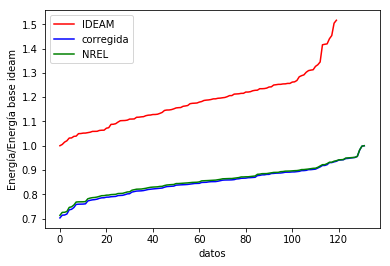

In [19]:
graficas(promedio_ideam_valledupar,promedio_nina_2010_valledupar,promedio_nrel_valledupar)